[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Downloaded data for GOOGL from 2022-01-01 to 2023-12-30
Downloaded data for AMZN from 2022-01-01 to 2023-12-30
Downloaded data for META from 2022-01-01 to 2023-12-30
Downloaded data for MSFT from 2022-01-01 to 2023-12-30
Downloaded data for AAPL from 2022-01-01 to 2023-12-30

Stock Data Date Ranges:

First Date in DataFrame: 2022-01-03 00:00:00
Last Date in DataFrame: 2023-12-29 00:00:00


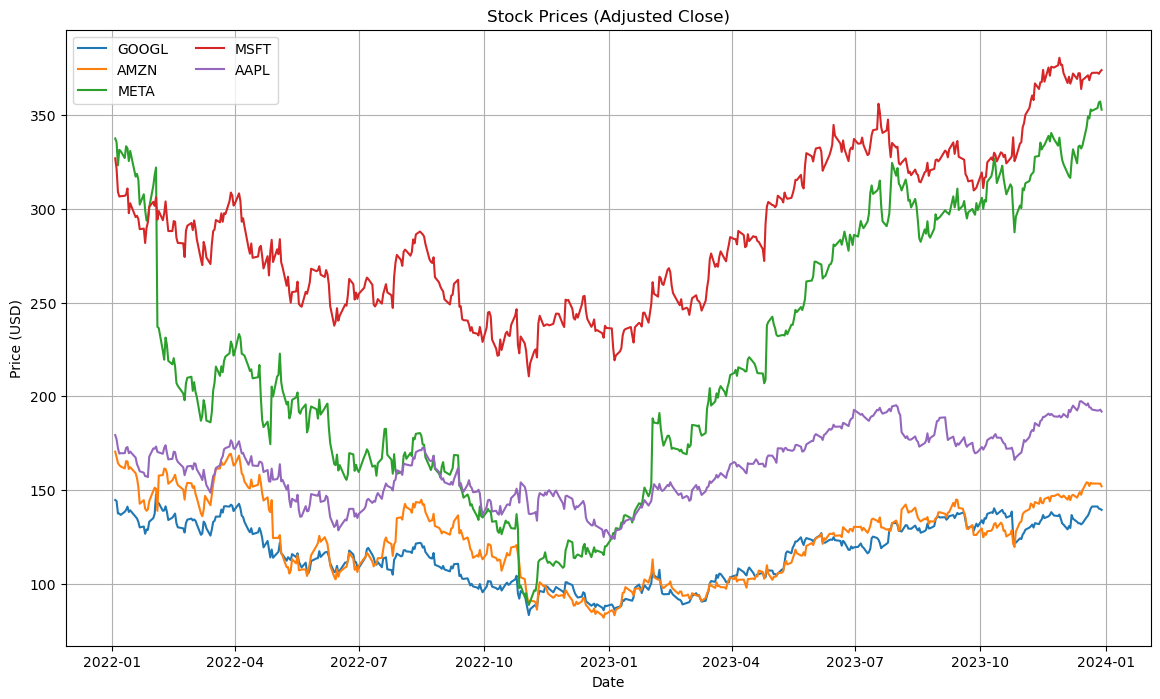

All stock data has been downloaded and saved successfully.


In [44]:
# Module 1: Download the stock prices for the BIG 5 Technology companies

import yfinance as yf
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import os

# Define the list of stock symbols
symbols = ['GOOGL', 'AMZN', 'META', 'MSFT', 'AAPL']

# Fixed start and end dates for the known periods
start_date = '2022-01-01'
end_date = '2023-12-30'

# Initialize an empty dictionary to store adjusted close prices
stock_data = {}

# Create directory for plots if not already existing
os.makedirs('plots', exist_ok=True)

# Loop through each symbol and download data
for symbol in symbols:
    try:
        # Fetch data from Yahoo Finance within the specified date range
        data = yf.download(symbol, start=start_date, end=end_date)
        # Check if the data is empty or has missing dates
        if data.empty:
            print(f"Warning: No data returned for {symbol}.")
            continue
        
        # Extract and store the adjusted closing price
        stock_data[symbol] = data['Adj Close']
        # Display a message confirming data download
        print(f"Downloaded data for {symbol} from {start_date} to {end_date}")
    except Exception as e:
        print(f"Error downloading data for {symbol}: {e}")

# Convert the dictionary to a DataFrame
stock_df = pd.DataFrame(stock_data)

# Ensure the DataFrame only contains the intended date range
stock_df = stock_df[(stock_df.index >= pd.to_datetime(start_date)) & (stock_df.index <= pd.to_datetime(end_date))]

# Fill any missing values (if any) using forward-fill/backward-fill
stock_df.ffill(inplace=True)
stock_df.bfill(inplace=True)

# Display the date range of the downloaded data
print("\nStock Data Date Ranges:\n")
first_date = stock_df.index.min()
last_date = stock_df.index.max()
print(f"First Date in DataFrame: {first_date}")
print(f"Last Date in DataFrame: {last_date}")

# Plot the stock prices
plt.figure(figsize=(14, 8))
for column in stock_df.columns:
    plt.plot(stock_df.index, stock_df[column], label=column)

plt.title('Stock Prices (Adjusted Close)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend(loc='upper left', ncol=2)
plt.grid(True)

# Save the plot to a PNG file
plt.savefig('plots/stock_prices.png')
plt.show()

# Save the combined DataFrame to a CSV file
stock_df.to_csv('combined_stock_data.csv')

print("All stock data has been downloaded and saved successfully.")


In [45]:
# Module 2: Download the cryptocurrency prices for the specified assets
# Amended to Add EMA12, EMA26, and BTC_diff columns for cryptocurrency data to match the transformations 
# done in stock data in subsequent analysis.
import requests
import pandas as pd
from datetime import datetime, timedelta

# Define your CryptoCompare API key
API_KEY = 'c7eacfd3b8089aeb623e92d0f549885e6b67f40c2c924796b72f916e6a70f98a'  # Existing API key

# Define the list of cryptocurrencies with their symbols
crypto_symbols = {
    'BTC': 'Bitcoin',
    'ETH': 'Ethereum',
    'USDT': 'Tether',
    'BNB': 'Binance Coin',
    'USDC': 'USD Coin'
}

# Define the start and end dates
start_date = '2022-01-01'
end_date = '2023-12-30'

# Convert dates to datetime objects
start_date_dt = datetime.strptime(start_date, '%Y-%m-%d')
end_date_dt = datetime.strptime(end_date, '%Y-%m-%d')

# Initialize an empty dictionary to store DataFrames
crypto_data = {}

# Function to fetch historical data for a given cryptocurrency
def fetch_crypto_data(symbol, start_date, end_date):
    all_data = []
    current_end_date = end_date

    while current_end_date > start_date:
        toTs = int(current_end_date.timestamp())
        url = f"https://min-api.cryptocompare.com/data/v2/histoday?fsym={symbol}&tsym=USD&limit=2000&toTs={toTs}&api_key={API_KEY}"
        response = requests.get(url)
        data = response.json()

        if data['Response'] == 'Success' and 'Data' in data['Data']:
            all_data.extend(data['Data']['Data'])
            earliest_date = pd.to_datetime(data['Data']['Data'][0]['time'], unit='s')
            current_end_date = earliest_date - timedelta(days=1)
        else:
            print(f"Error fetching data for {symbol}: {data.get('Message', 'Unknown error')}")
            break

    df = pd.DataFrame(all_data)
    if not df.empty:
        df['time'] = pd.to_datetime(df['time'], unit='s')
        df.set_index('time', inplace=True)
        df = df[['close']]  # Keep only the close price
        df.columns = [symbol]
        # Add feature engineering for consistency
        df[f'{symbol}_diff'] = df[symbol].diff()
        df[f'{symbol}_EMA12'] = df[symbol].ewm(span=12, adjust=False).mean()
        df[f'{symbol}_EMA26'] = df[symbol].ewm(span=26, adjust=False).mean()
        # Filter data to ensure it matches the intended date range
        df = df[(df.index >= start_date) & (df.index <= end_date)]
    else:
        print(f"No data returned for {symbol}")

    return df

# Loop through each cryptocurrency and download data
for symbol, name in crypto_symbols.items():
    df = fetch_crypto_data(symbol, start_date_dt, end_date_dt)
    if not df.empty:
        crypto_data[name] = df
        print(f"Downloaded data for {name} from {start_date} to {end_date}")
    else:
        print(f"Failed to download data for {name}")

# Combine all data into a single DataFrame
if crypto_data:
    crypto_df = pd.concat(crypto_data.values(), axis=1)
    crypto_df.to_csv('crypto_data_combined.csv')
    print("All cryptocurrency data has been downloaded and saved successfully.")
else:
    print("No data was successfully downloaded.")


Downloaded data for Bitcoin from 2022-01-01 to 2023-12-30
Downloaded data for Ethereum from 2022-01-01 to 2023-12-30
Downloaded data for Tether from 2022-01-01 to 2023-12-30
Downloaded data for Binance Coin from 2022-01-01 to 2023-12-30
Downloaded data for USD Coin from 2022-01-01 to 2023-12-30
All cryptocurrency data has been downloaded and saved successfully.


Data combined successfully without missing values.


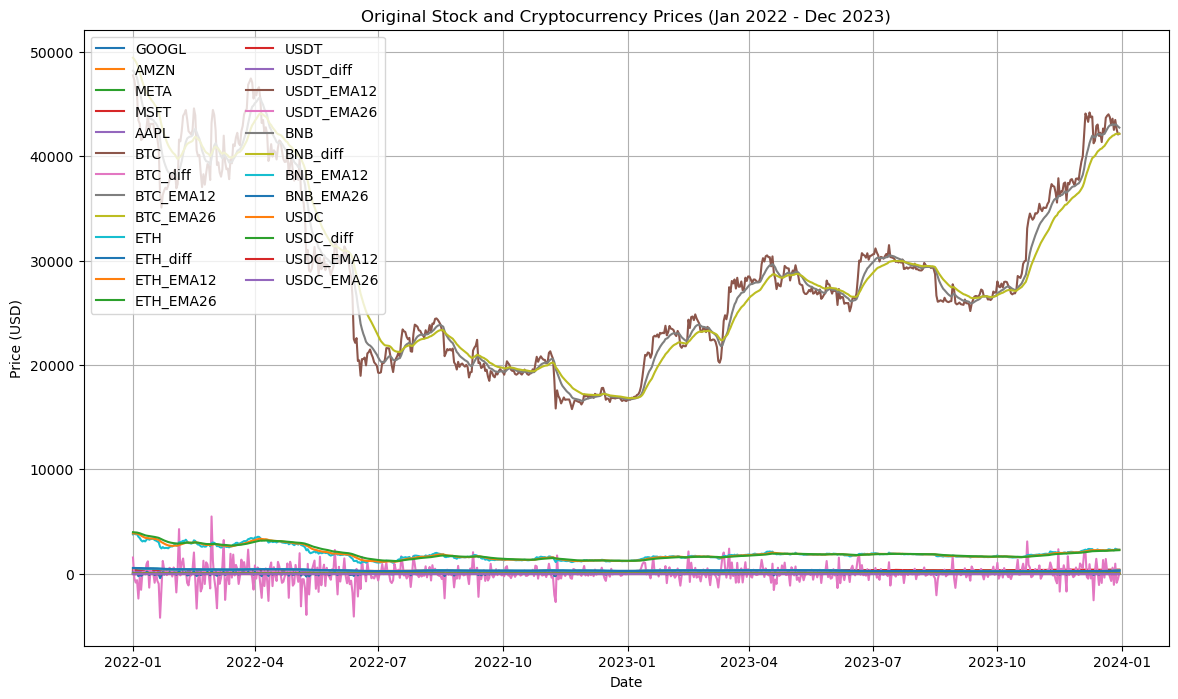


First few rows of the normalized DataFrame:
                GOOGL      AMZN      META      MSFT      AAPL       BTC  \
2022-01-01  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
2022-01-02  1.000000  1.000000  1.000000  1.000000  1.000000  0.990973   
2022-01-03  1.000000  1.000000  1.000000  1.000000  1.000000  0.973049   
2022-01-04  0.995917  0.983084  0.994063  0.982853  0.987308  0.959931   
2022-01-05  0.950228  0.964511  0.957553  0.945123  0.961046  0.909822   

            BTC_diff  BTC_EMA12  BTC_EMA26       ETH  ...  USDT_EMA12  \
2022-01-01  1.000000   1.000000   1.000000  1.000000  ...    1.000000   
2022-01-02 -0.279824   0.997222   0.996815  1.017039  ...    0.999977   
2022-01-03 -0.555583   0.992140   0.992583  0.999581  ...    0.999957   
2022-01-04 -0.406645   0.985839   0.987727  1.005026  ...    0.999894   
2022-01-05 -1.553226   0.972869   0.979646  0.938947  ...    0.999872   

            USDT_EMA26       BNB  BNB_diff  BNB_EMA12  BNB_EMA26    US

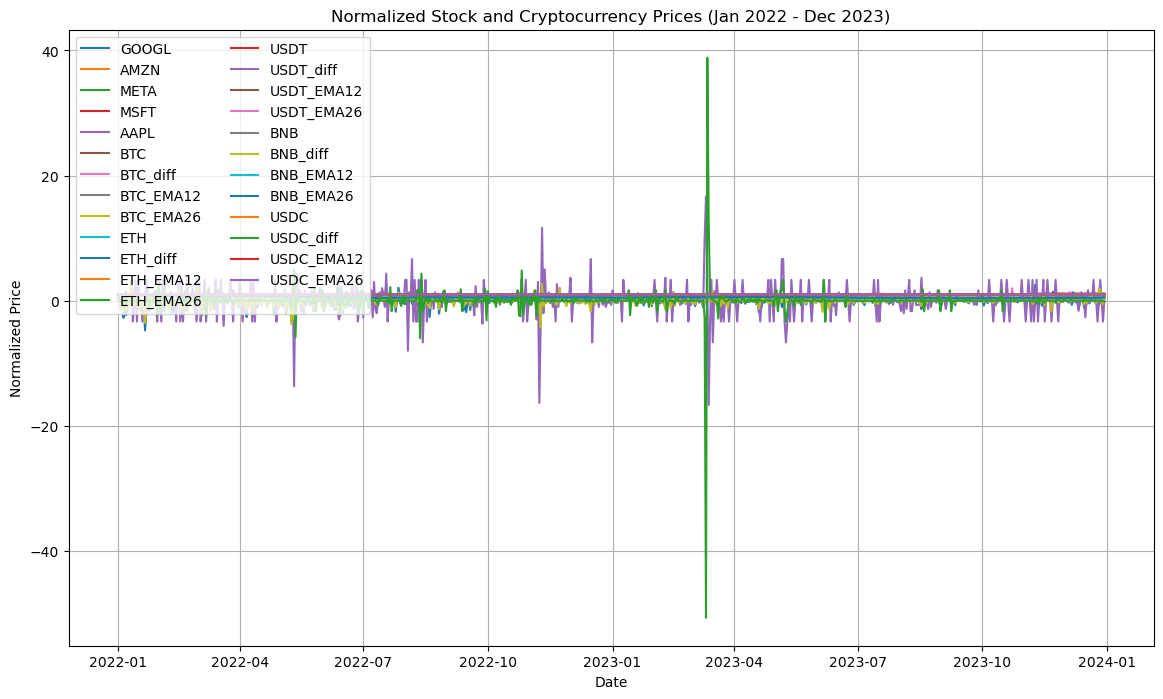

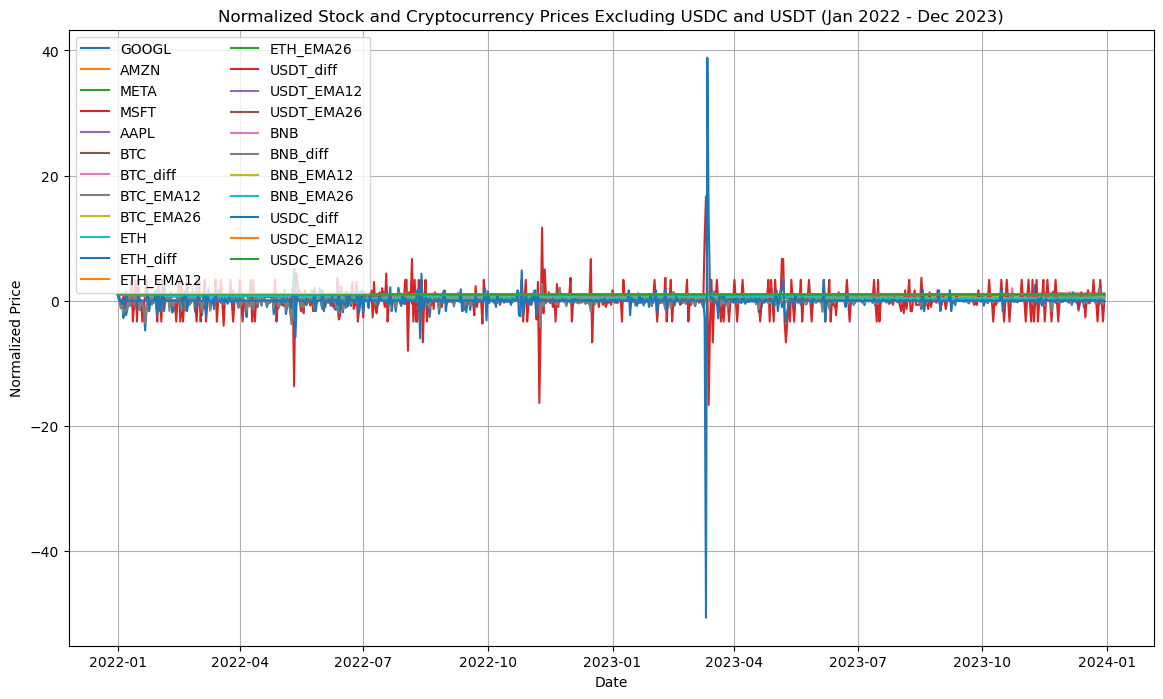

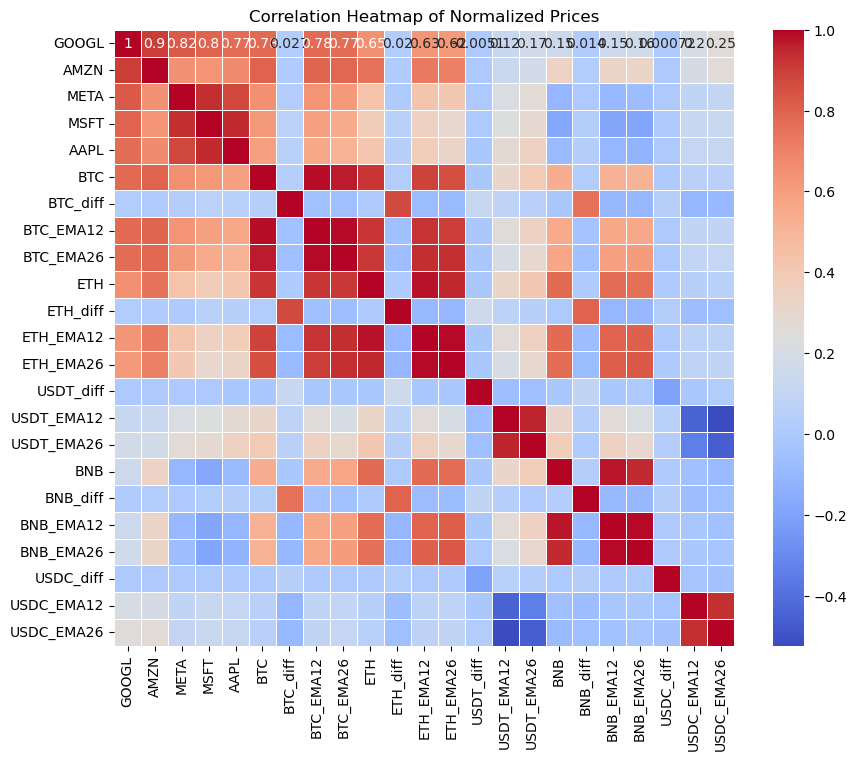

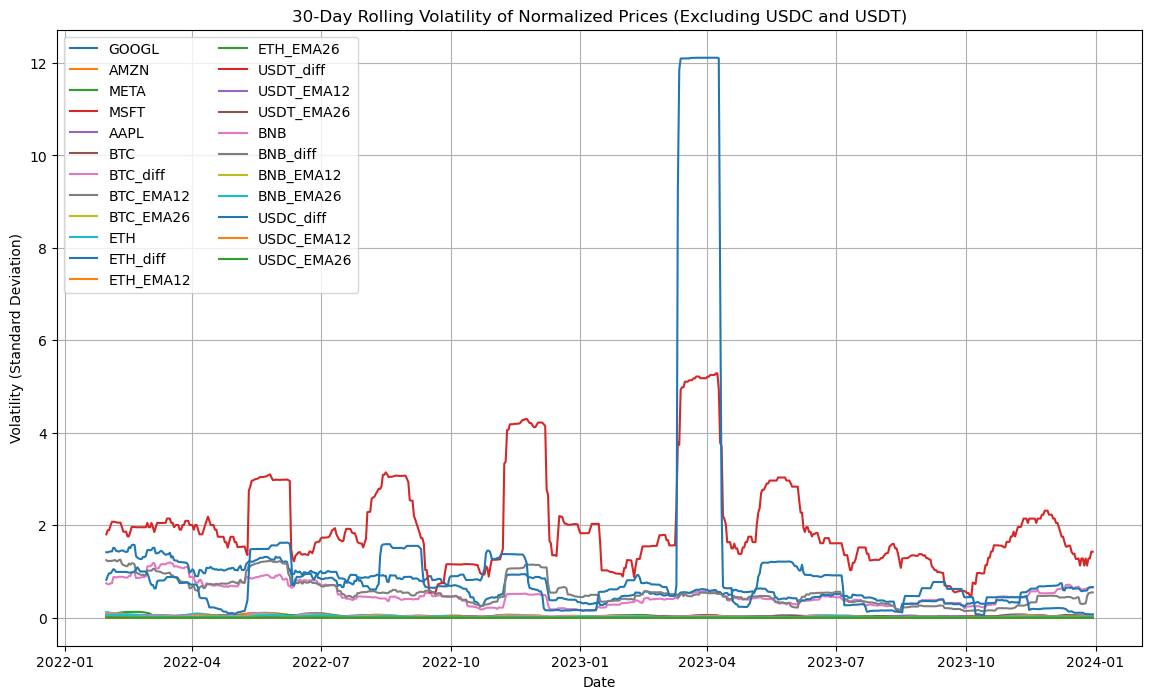

In [46]:
# Module 3: Lets explore the data in a "test" dataframe and chart the results and look for patterns.
# First change - the price of BTC is so high charting the data isn't informative, lets normalize the prices.
# Second change is to drop Tether USDT and US Dollar coin USDC from the consideration, as both of them are
# clearly pegged to the dollar, and are flat line that I don't think will add anything to the analysis

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os

# Ensure the plots directory exists
os.makedirs('plots', exist_ok=True)

# Combine both datasets into a single DataFrame named explore_combined_df
# Ensure that stock_df and crypto_df are already available from the previous steps
explore_combined_df = pd.concat([stock_df, crypto_df], axis=1)

# Check for any missing data and fill forward/backward
explore_combined_df = explore_combined_df.ffill().bfill()

# Verify that there are no missing values after filling
if explore_combined_df.isnull().values.any():
    print("Warning: Missing values found after fill. Please check the data.")
else:
    print("Data combined successfully without missing values.")

# Plot the original stock and cryptocurrency prices
plt.figure(figsize=(14, 8))
for column in explore_combined_df.columns:
    plt.plot(explore_combined_df.index, explore_combined_df[column], label=column)

plt.title('Original Stock and Cryptocurrency Prices (Jan 2022 - Dec 2023)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend(loc='upper left', ncol=2)
plt.grid(True)
plt.savefig('plots/original_prices.png')
plt.show()

# Normalize each stock and cryptocurrency price separately to start at 1 within explore_combined_df
explore_combined_df = explore_combined_df.apply(lambda x: x / x.iloc[0])

# Display the first few rows of the normalized DataFrame for verification
print("\nFirst few rows of the normalized DataFrame:\n", explore_combined_df.head())

# Plot the normalized data to visualize the relative performance
plt.figure(figsize=(14, 8))
for column in explore_combined_df.columns:
    plt.plot(explore_combined_df.index, explore_combined_df[column], label=column)

plt.title('Normalized Stock and Cryptocurrency Prices (Jan 2022 - Dec 2023)')
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.legend(loc='upper left', ncol=2)
plt.grid(True)
plt.savefig('plots/normalized_prices.png')
plt.show()

# Remove 'USDC' and 'USDT' from the explore_combined_df for the next plot
explore_combined_df_no_usdc_usdt = explore_combined_df.drop(columns=['USDC', 'USDT'], errors='ignore')

# Plot the normalized data excluding USDC and USDT
plt.figure(figsize=(14, 8))
for column in explore_combined_df_no_usdc_usdt.columns:
    plt.plot(explore_combined_df_no_usdc_usdt.index, explore_combined_df_no_usdc_usdt[column], label=column)

plt.title('Normalized Stock and Cryptocurrency Prices Excluding USDC and USDT (Jan 2022 - Dec 2023)')
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.legend(loc='upper left', ncol=2)
plt.grid(True)
plt.savefig('plots/normalized_prices_excluding_usdc_usdt.png')
plt.show()

# Additional Visualization: Correlation Heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = explore_combined_df_no_usdc_usdt.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Normalized Prices')
plt.savefig('plots/correlation_heatmap.png')
plt.show()

# Additional Visualization: Rolling Volatility (30-day rolling standard deviation)
plt.figure(figsize=(14, 8))
for column in explore_combined_df_no_usdc_usdt.columns:
    rolling_volatility = explore_combined_df_no_usdc_usdt[column].rolling(window=30).std()
    plt.plot(rolling_volatility, label=column)

plt.title('30-Day Rolling Volatility of Normalized Prices (Excluding USDC and USDT)')
plt.xlabel('Date')
plt.ylabel('Volatility (Standard Deviation)')
plt.legend(loc='upper left', ncol=2)
plt.grid(True)
plt.savefig('plots/rolling_volatility.png')
plt.show()


In [47]:
# Module 4 - Data preparation and feature engineering for the main analysis.
# Lets focus on BTC. Align the stock and BTC data, create lagged features, rolling averages, and future 
# price targets for BTC.
# Amended to centralize the feature engineering logic into a reusable function (create_features()). 
# This function will ensure that any feature engineering steps used in Modules 2 and 8 are consistent and compatible 
# across the entire project.

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from statsmodels.tsa.stattools import adfuller

def create_features(df):
    """Create features like lags, rolling averages, EMAs, and volatility."""
    feature_dict = {}  # Dictionary to hold all new features
    
    for col in df.columns:
        # Add lagged features
        for lag in [1, 7, 14, 28]:
            feature_dict[f'{col}_lag{lag}'] = df[col].shift(lag)
        
        # Add rolling averages
        for window in [7, 14, 28]:
            feature_dict[f'{col}_rolling{window}'] = df[col].rolling(window).mean()
        
        # Add Exponential Moving Averages (EMA)
        feature_dict[f'{col}_EMA12'] = df[col].ewm(span=12, adjust=False).mean()
        feature_dict[f'{col}_EMA26'] = df[col].ewm(span=26, adjust=False).mean()
        
        # Calculate volatility (standard deviation over a 14-day window)
        feature_dict[f'{col}_volatility'] = df[col].rolling(14).std()

    # Convert the dictionary to a DataFrame
    features_df = pd.DataFrame(feature_dict, index=df.index)
    
    # Concatenate the original DataFrame with the new features DataFrame
    df = pd.concat([df, features_df], axis=1)

    # Drop rows with NaN values after feature creation
    df.dropna(inplace=True)
    return df

# Assume stock_df contains stock prices and crypto_df contains cryptocurrency prices (e.g., BTC)
# Apply feature engineering function to both DataFrames
stock_df = create_features(stock_df)
crypto_df = create_features(crypto_df[['BTC']])  # Apply to BTC column only

# Combine stock and BTC data into one DataFrame for modeling
combined_data = pd.concat([stock_df, crypto_df], axis=1)

# Impute missing values if necessary
imputer = SimpleImputer(strategy='mean')
combined_data = pd.DataFrame(imputer.fit_transform(combined_data), columns=combined_data.columns, index=combined_data.index)

# Create the target variable: BTC future prices at different intervals
futures = [0, 1, 7, 14, 28]  # Include 0 to predict the current BTC price
for future in futures:
    combined_data[f'BTC_{future}d'] = combined_data['BTC'].shift(-future)

# Create the differenced feature for stationarity checks (ARIMA/SARIMA)
combined_data['BTC_diff'] = combined_data['BTC'].diff()

# Drop rows with NaN values after all transformations
combined_data.dropna(inplace=True)

# Feature Scaling: Scale the features for Linear Regression and Random Forest
scaler = StandardScaler()
scaled_features = scaler.fit_transform(combined_data.drop(columns=[f'BTC_{f}d' for f in futures]))

# Perform ADF test to check stationarity
adf_test = adfuller(combined_data['BTC_diff'])
print(f'ADF Statistic: {adf_test[0]}, p-value: {adf_test[1]}')

# Remove highly correlated features using VarianceThreshold (if applicable)
selector = VarianceThreshold(threshold=0.1)
selected_features = selector.fit_transform(scaled_features)

# Train-Test Split: Split data into training and test sets, ensuring no leakage of future data
train_data = combined_data[:'2023-06-30']
test_data = combined_data['2023-07-01':]

# Display the first and last dates in the DataFrame
first_date = combined_data.index.min()
last_date = combined_data.index.max()
print(f"\nFirst Date in DataFrame: {first_date}")
print(f"Last Date in DataFrame: {last_date}")

# Output the combined data to a CSV file for visual inspection
combined_data.to_csv('combined_data.csv', index=True)  # Save the DataFrame to a CSV file
print("Data saved to combined_data.csv for visual inspection.")


ADF Statistic: -8.338560792232066, p-value: 3.222310460970316e-13

First Date in DataFrame: 2022-01-30 00:00:00
Last Date in DataFrame: 2023-12-02 00:00:00
Data saved to combined_data.csv for visual inspection.


In [48]:
# Module 5: Modeling BTC Price Prediction Using Various Techniques (Linear Regression, ARIMA, SARIMA, 
# Random Fores (and adding LSTM) for Different BTC Price Intervals. 
# Amended to include changes to ensure feature consistency.

import pandas as pd
import numpy as np
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Suppress warnings
warnings.filterwarnings("ignore")

# Load the prepared data
combined_data = pd.read_csv('combined_data.csv', index_col=0, parse_dates=True)

# Define features (X) and targets (y) for modeling
features = combined_data.drop(columns=['BTC_0d', 'BTC_1d', 'BTC_7d', 'BTC_14d', 'BTC_28d', 'BTC_diff'])
targets = combined_data[['BTC_0d', 'BTC_1d', 'BTC_7d', 'BTC_14d', 'BTC_28d']]

# Split data into training and testing sets (80% train, 20% test)
cutoff_date = int(len(combined_data) * 0.8)
X_train, X_test = features.iloc[:cutoff_date], features.iloc[cutoff_date:]
y_train, y_test = targets.iloc[:cutoff_date], targets.iloc[cutoff_date:]

# Initialize a list to collect results
results_list = []

# 1. Linear Regression Model
for col in y_train.columns:
    lr = LinearRegression()
    lr.fit(X_train, y_train[col])
    y_pred = lr.predict(X_test)
    results_list.append({
        'Model': 'Linear Regression',
        'Target': col,
        'RMSE': np.sqrt(mean_squared_error(y_test[col], y_pred)),
        'R2': r2_score(y_test[col], y_pred)
    })

# 2. ARIMA and SARIMA Models for each target interval
for col in y_train.columns:
    # ARIMA Model
    arima_model = auto_arima(y_train[col], seasonal=False, trace=False, error_action='ignore', suppress_warnings=True)
    arima_pred = arima_model.predict(n_periods=len(y_test))
    results_list.append({
        'Model': 'ARIMA',
        'Target': col,
        'RMSE': np.sqrt(mean_squared_error(y_test[col], arima_pred)),
        'R2': r2_score(y_test[col], arima_pred)
    })
    
    # SARIMA Model
    sarima_model = SARIMAX(y_train[col], order=arima_model.order, seasonal_order=(1, 1, 1, 12))
    sarima_fit = sarima_model.fit(disp=False)
    sarima_pred = sarima_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)
    results_list.append({
        'Model': 'SARIMA',
        'Target': col,
        'RMSE': np.sqrt(mean_squared_error(y_test[col], sarima_pred)),
        'R2': r2_score(y_test[col], sarima_pred)
    })

# 3. Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
for col in y_train.columns:
    rf_model.fit(X_train, y_train[col])
    y_pred = rf_model.predict(X_test)
    results_list.append({
        'Model': 'Random Forest',
        'Target': col,
        'RMSE': np.sqrt(mean_squared_error(y_test[col], y_pred)),
        'R2': r2_score(y_test[col], y_pred)
    })

# Convert the results list to a DataFrame
results_df = pd.DataFrame(results_list)

# Save the results to a CSV file
results_df.to_csv('model_performance_summary.csv', index=False)
print("Model evaluation complete. Results saved to 'model_performance_summary.csv'.")


Model evaluation complete. Results saved to 'model_performance_summary.csv'.



Model Performance Summary Across Time Intervals:
                 Model   Target          RMSE        R2
0   Linear Regression   BTC_0d  1.522681e-11  1.000000
1   Linear Regression   BTC_1d  7.808008e+02  0.967041
2   Linear Regression   BTC_7d  2.605745e+03  0.737806
3   Linear Regression  BTC_14d  4.679665e+03  0.319642
4   Linear Regression  BTC_28d  7.544565e+03 -0.327128
5               ARIMA   BTC_0d  4.234995e+03 -0.008009
6              SARIMA   BTC_0d  3.794221e+03  0.190897
7               ARIMA   BTC_1d  4.315058e+03 -0.006632
8              SARIMA   BTC_1d  3.922862e+03  0.168038
9               ARIMA   BTC_7d  5.355321e+03 -0.107467
10             SARIMA   BTC_7d  4.689867e+03  0.150662
11              ARIMA  BTC_14d  6.181719e+03 -0.187207
12             SARIMA  BTC_14d  7.994943e+03 -0.985814
13              ARIMA  BTC_28d  9.298938e+03 -1.016095
14             SARIMA  BTC_28d  1.037352e+04 -1.508974
15      Random Forest   BTC_0d  1.433288e+03  0.884542
16      Random

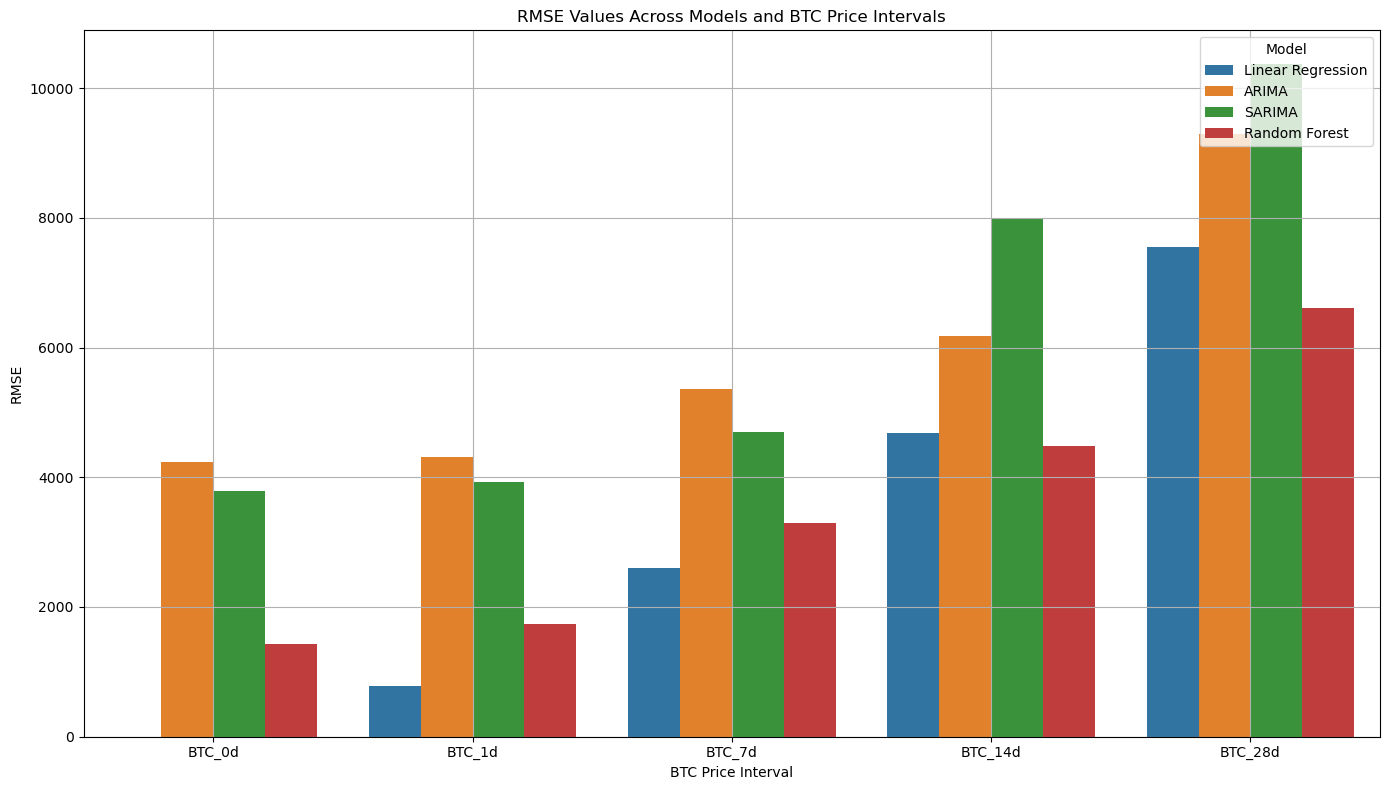

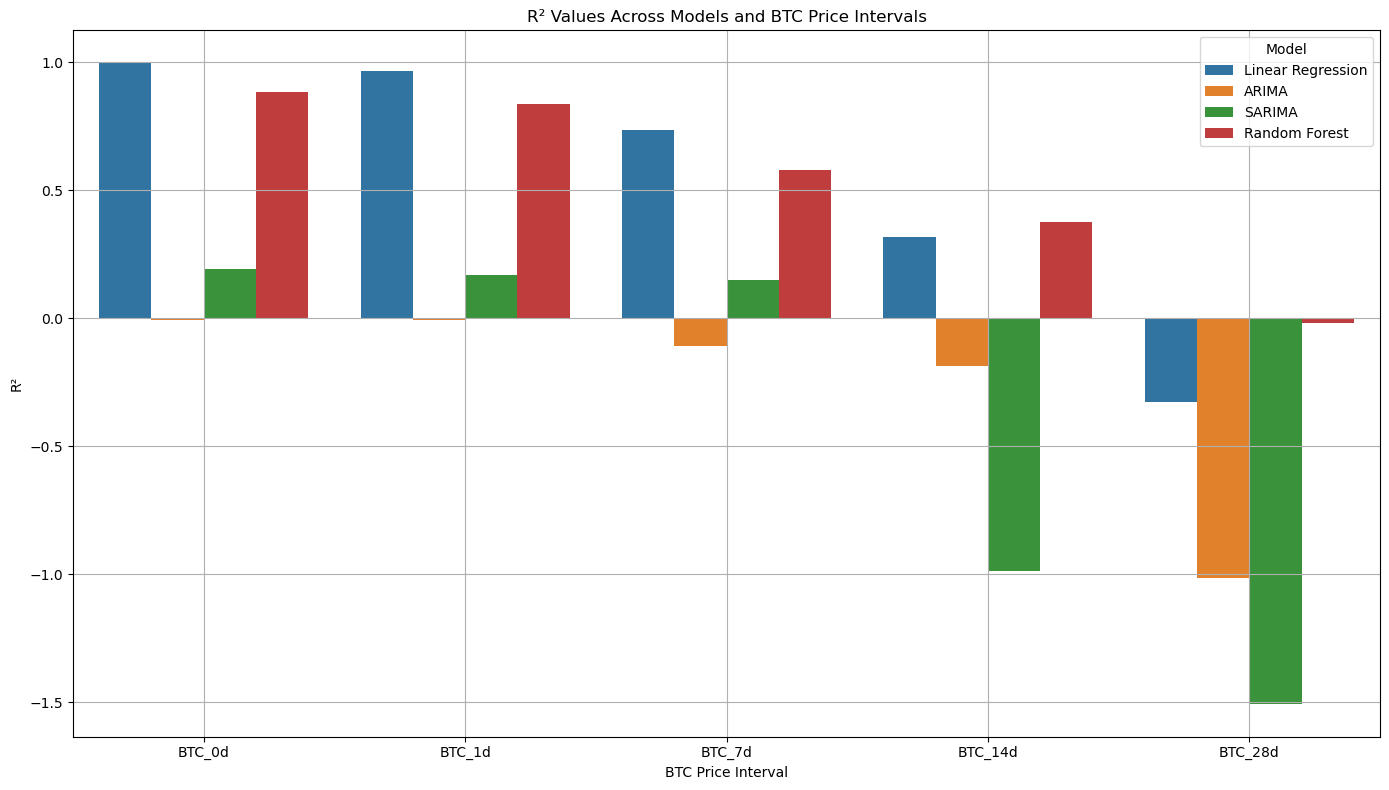

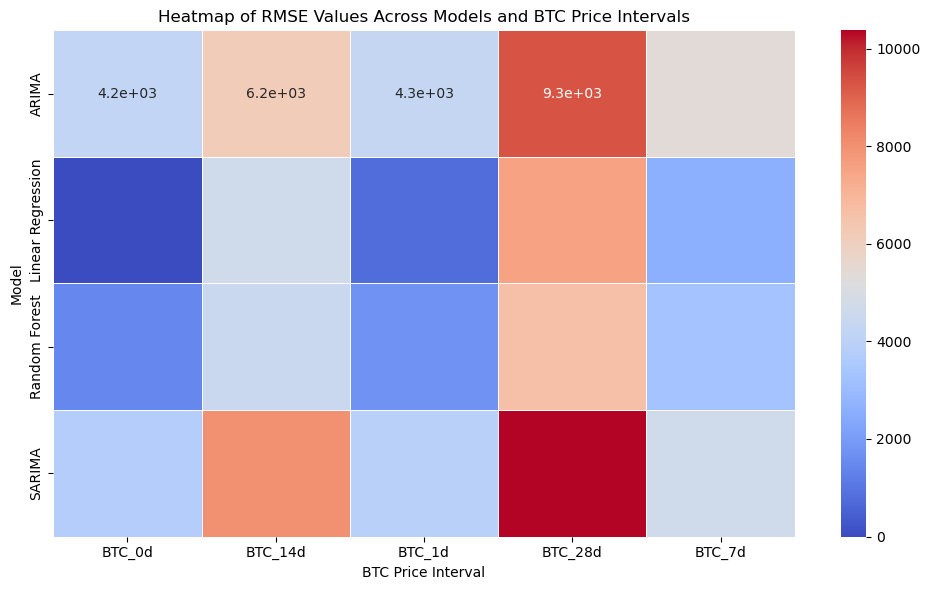

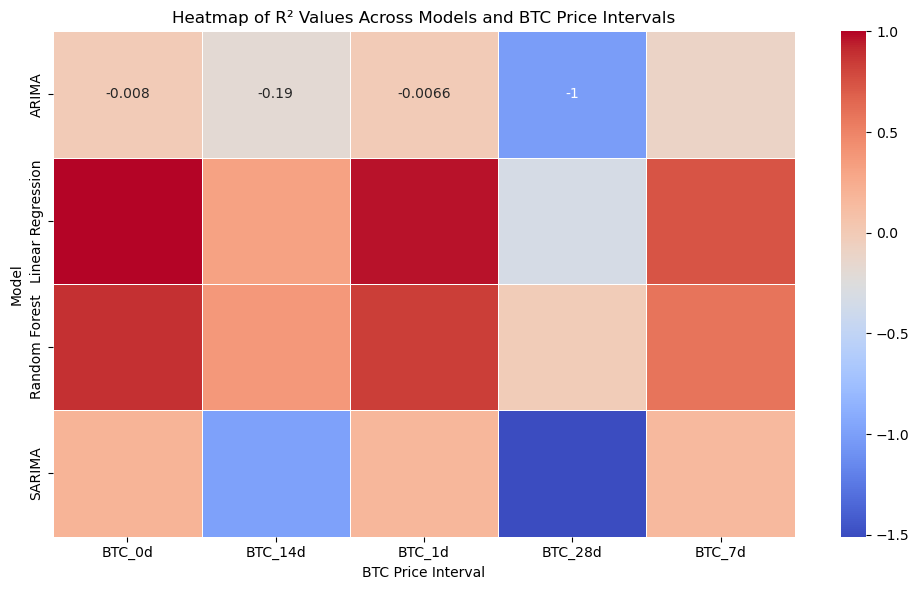


Summary of Average RMSE and R² Across All Intervals:
                Model         RMSE        R2
0              ARIMA  5877.206211 -0.265082
1  Linear Regression  3122.155198  0.539472
2      Random Forest  3509.771974  0.532218
3             SARIMA  6155.081840 -0.397038


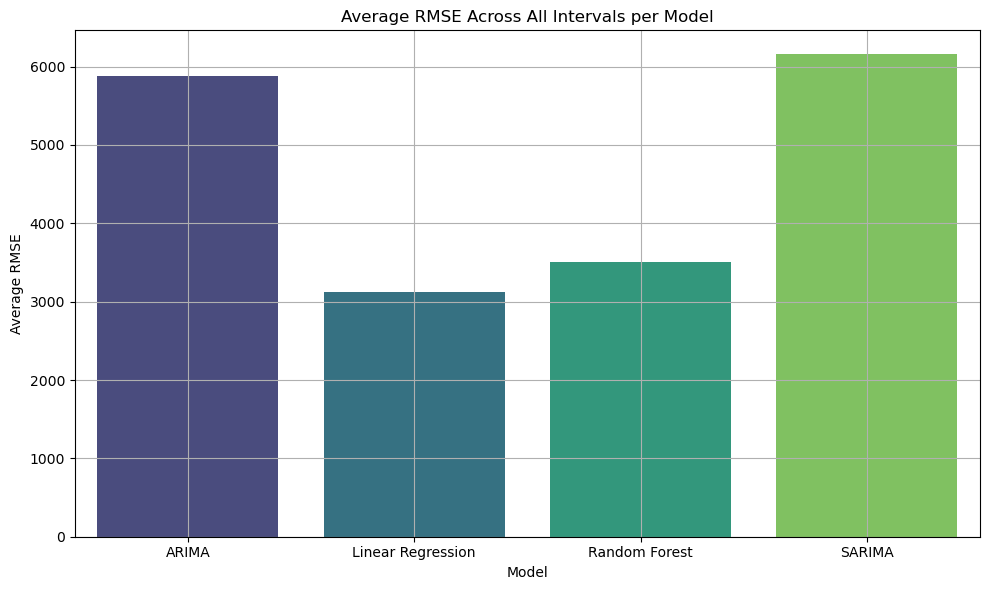

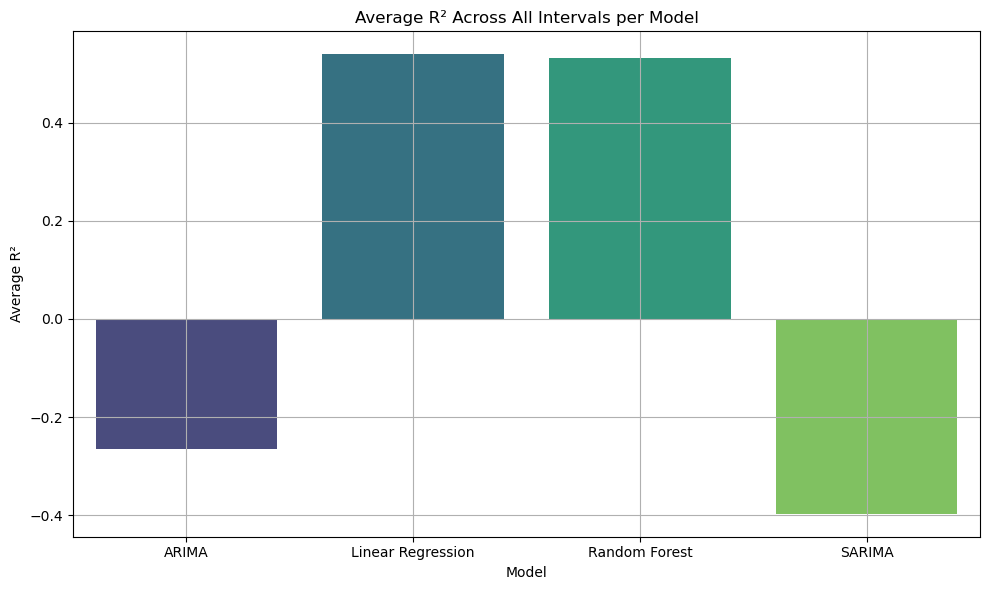

In [11]:
# Module 6 - Evaluate the performance of each model and compare how well they predict future BTC prices at 
# different intervals.

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load the model performance results from Module 5
results_df = pd.read_csv('model_performance_summary.csv')

# Ensure the plots directory exists
os.makedirs('plots', exist_ok=True)

# Display the summary table of results
print("\nModel Performance Summary Across Time Intervals:\n", results_df)

# Plot RMSE values for each model across the BTC price intervals
plt.figure(figsize=(14, 8))
sns.barplot(data=results_df, x='Target', y='RMSE', hue='Model')
plt.title('RMSE Values Across Models and BTC Price Intervals')
plt.xlabel('BTC Price Interval')
plt.ylabel('RMSE')
plt.legend(loc='upper right', title='Model')
plt.grid(True)
plt.tight_layout()
plt.savefig('plots/rmse_comparison.png')
plt.show()

# Plot R-squared values for each model across the BTC price intervals
plt.figure(figsize=(14, 8))
sns.barplot(data=results_df, x='Target', y='R2', hue='Model')
plt.title('R² Values Across Models and BTC Price Intervals')
plt.xlabel('BTC Price Interval')
plt.ylabel('R²')
plt.legend(loc='upper right', title='Model')
plt.grid(True)
plt.tight_layout()
plt.savefig('plots/r2_comparison.png')
plt.show()

# Create a pivot table for heatmap visualization of RMSE and R² values
pivot_rmse = results_df.pivot_table(index='Model', columns='Target', values='RMSE', aggfunc='mean')
pivot_r2 = results_df.pivot_table(index='Model', columns='Target', values='R2', aggfunc='mean')

# Heatmap for RMSE values
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_rmse, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap of RMSE Values Across Models and BTC Price Intervals')
plt.xlabel('BTC Price Interval')
plt.ylabel('Model')
plt.tight_layout()
plt.savefig('plots/rmse_heatmap.png')
plt.show()

# Heatmap for R-squared values
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_r2, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap of R² Values Across Models and BTC Price Intervals')
plt.xlabel('BTC Price Interval')
plt.ylabel('Model')
plt.tight_layout()
plt.savefig('plots/r2_heatmap.png')
plt.show()

# Summary Table: Calculate average RMSE and R² for each model across all intervals
summary_df = results_df.groupby('Model').agg({
    'RMSE': 'mean',
    'R2': 'mean'
}).reset_index()

# Display the summary table
print("\nSummary of Average RMSE and R² Across All Intervals:\n", summary_df)

# Save the summary table to a CSV file
summary_df.to_csv('model_performance_summary_averages.csv', index=False)

# Optional: Visualize the average performance summary
plt.figure(figsize=(10, 6))
sns.barplot(data=summary_df, x='Model', y='RMSE', palette='viridis')
plt.title('Average RMSE Across All Intervals per Model')
plt.xlabel('Model')
plt.ylabel('Average RMSE')
plt.grid(True)
plt.tight_layout()
plt.savefig('plots/average_rmse_per_model.png')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(data=summary_df, x='Model', y='R2', palette='viridis')
plt.title('Average R² Across All Intervals per Model')
plt.xlabel('Model')
plt.ylabel('Average R²')
plt.grid(True)
plt.tight_layout()
plt.savefig('plots/average_r2_per_model.png')
plt.show()



Evaluating Baseline configuration...

Training LSTM for BTC_0d using Baseline configuration...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Training LSTM for BTC_1d using Baseline configuration...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Training LSTM for BTC_7d using Baseline configuration...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Training LSTM for BTC_14d using Baseline configuration...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Training LSTM for BTC_28d using Baseline configuration...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

Evaluating Configuration 1 configuration...

Training LSTM for BTC_0d using Configuration 1 configuration...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Training LSTM for BTC_1d using Configuration 1 configuration...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Training LSTM for BTC_7d using Configuration 1 configuration...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Training LSTM for BTC_14d using Configuration 1 configuration...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Training LSTM for BTC_28d usi

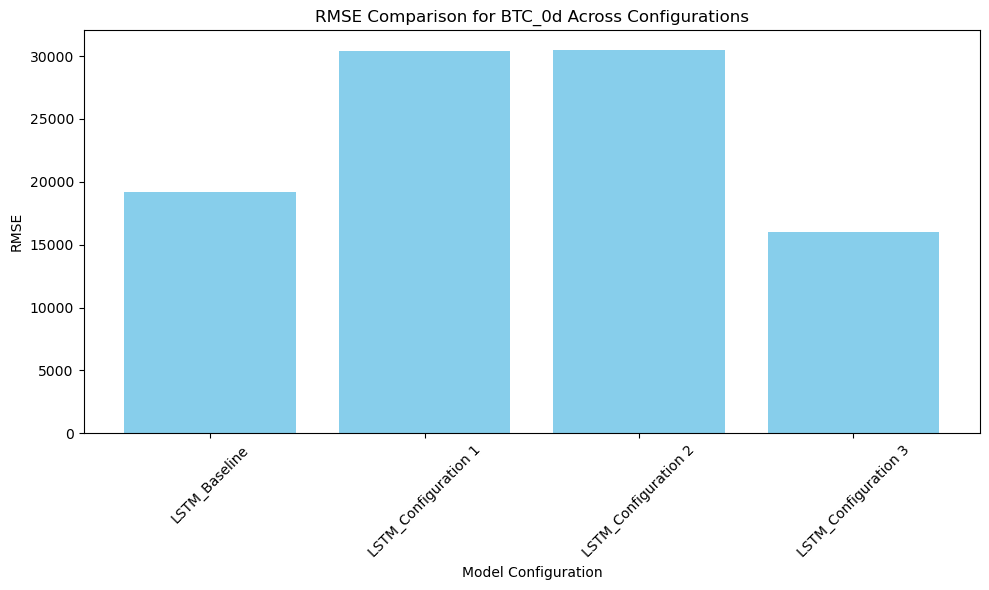

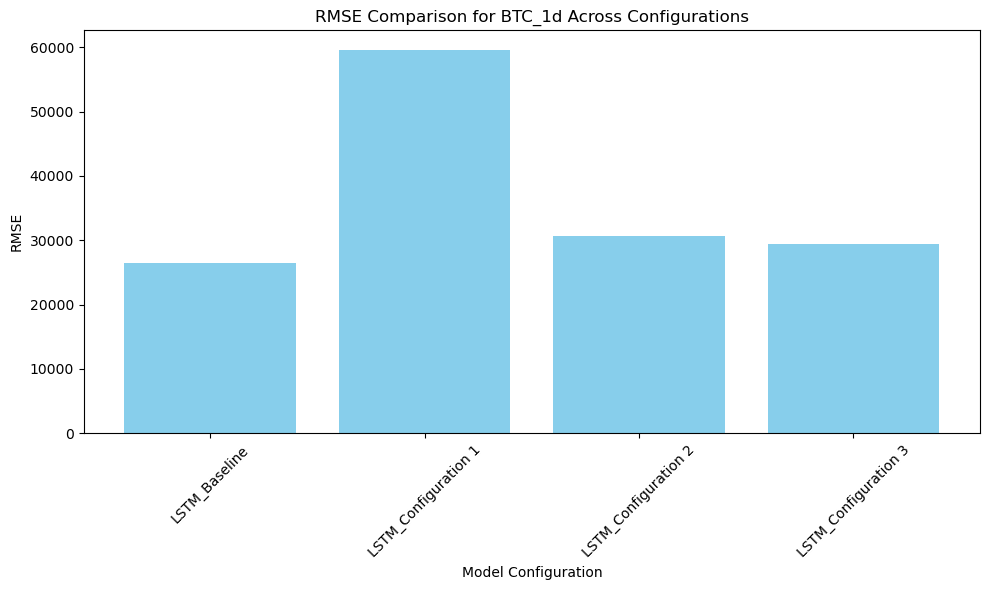

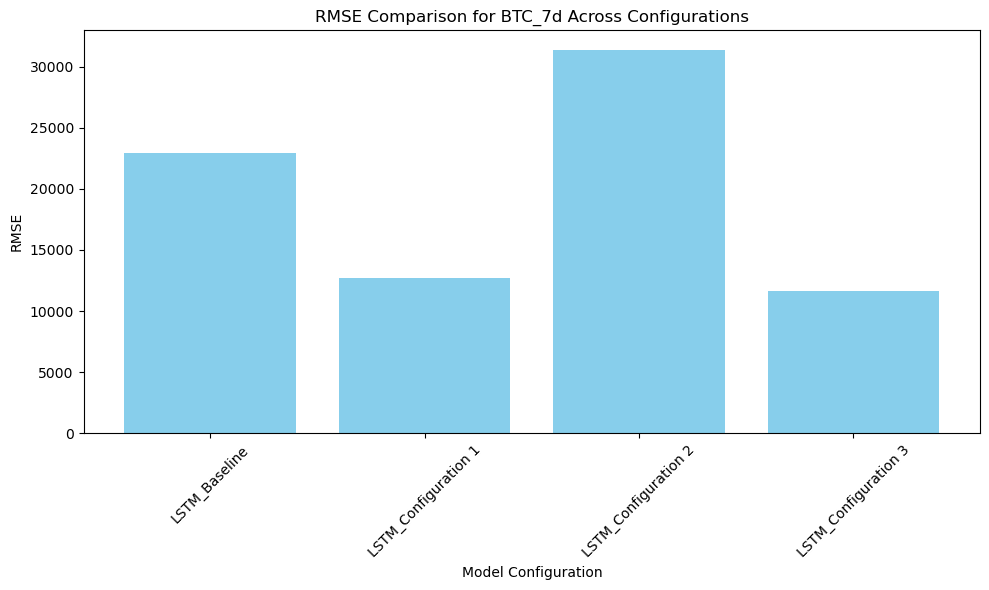

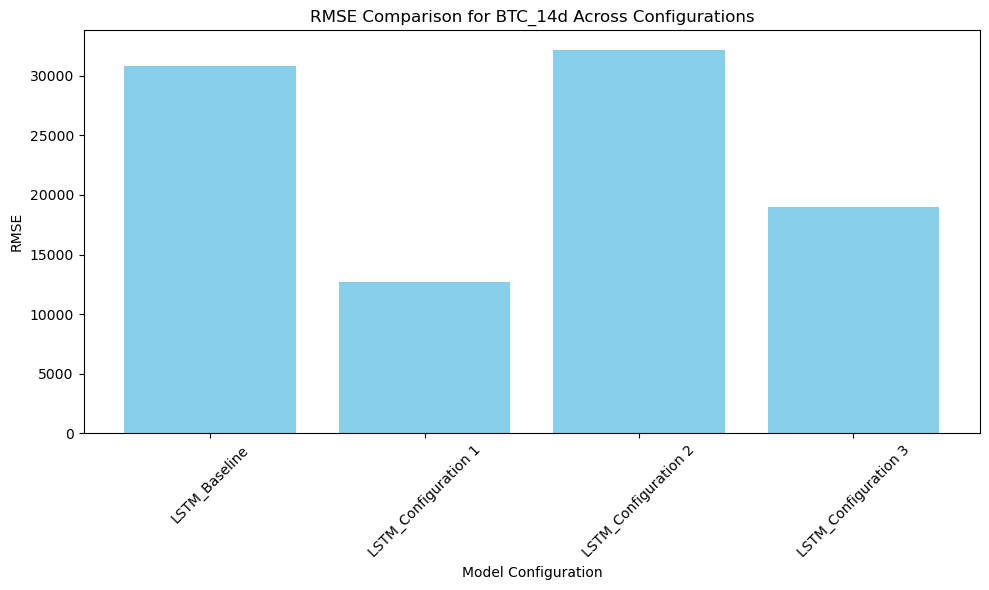

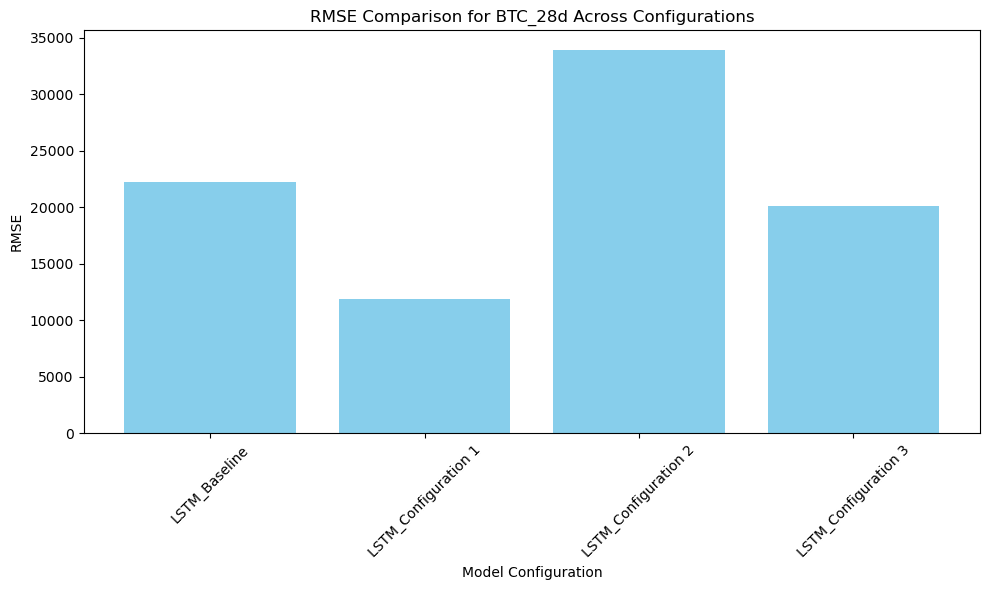

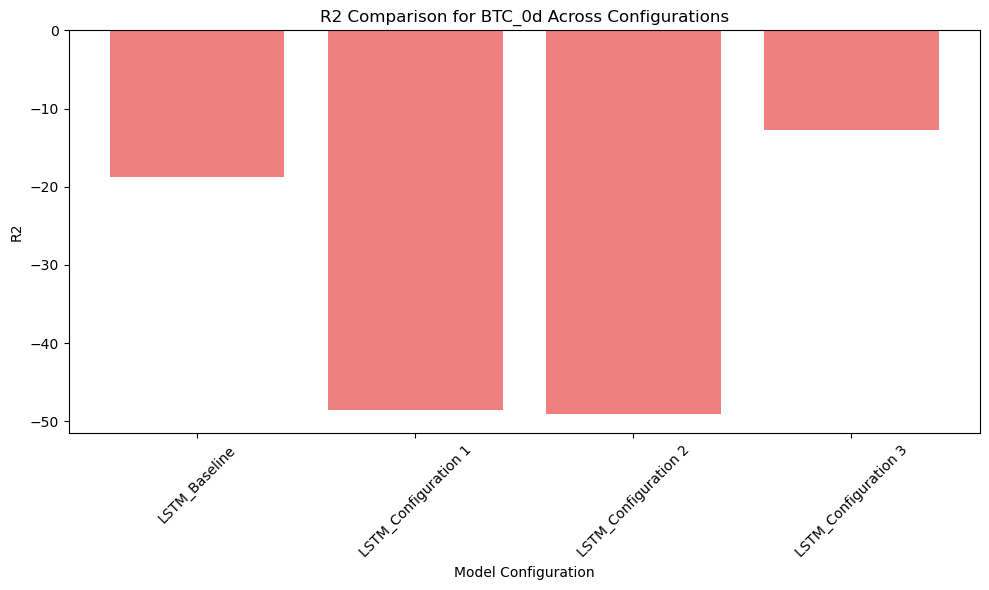

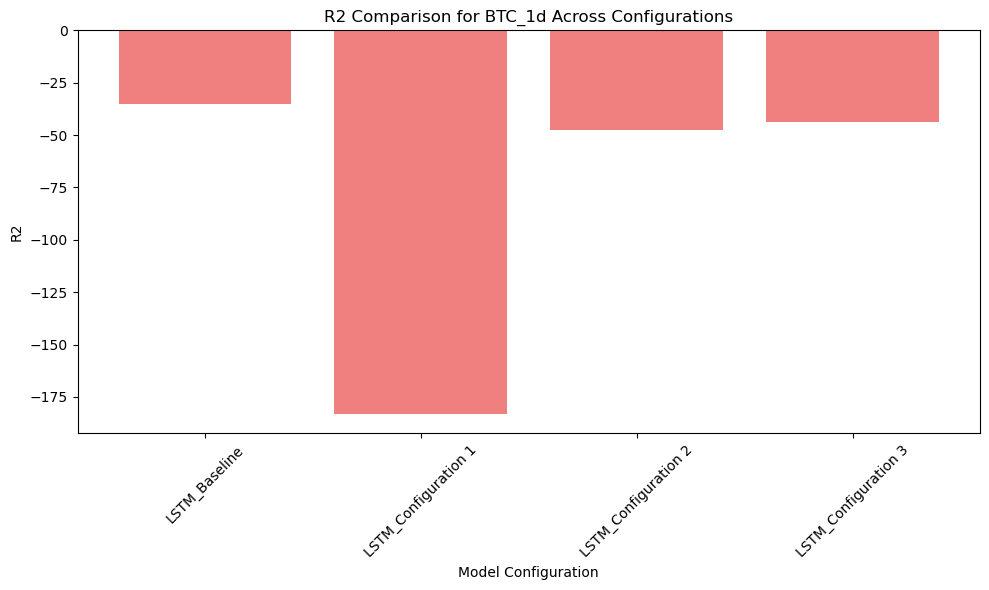

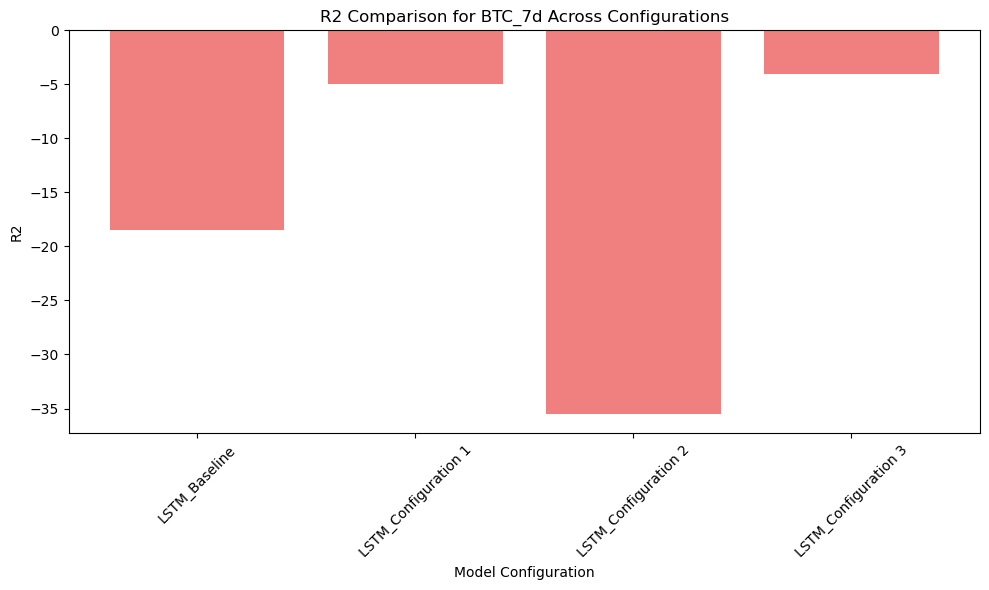

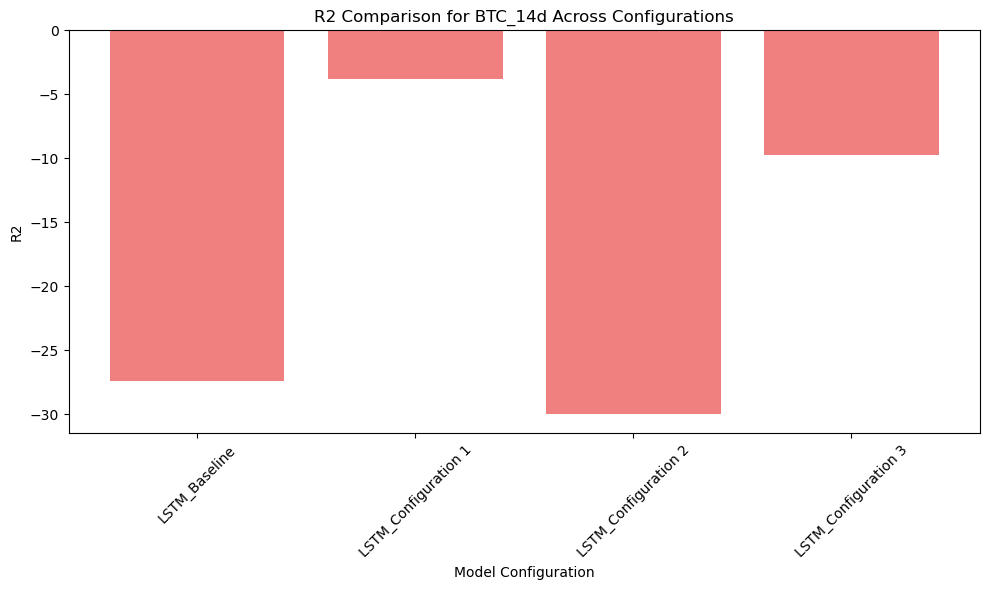

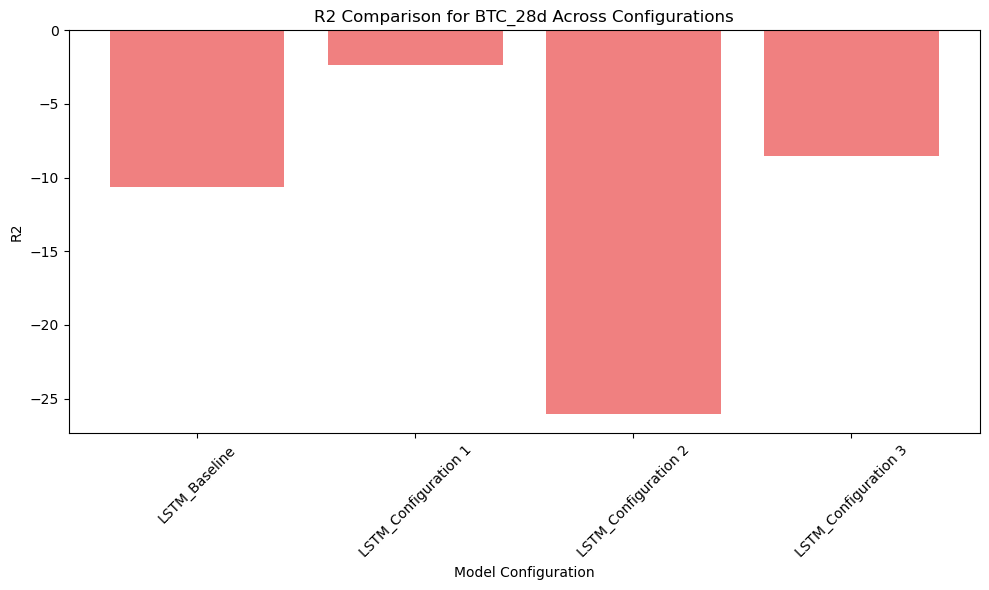

In [49]:
# Module 7: Implementing the LSTM Model
# Updated to experiment with Different LSTM Configurations and Compare Results

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Load the prepared data
combined_data = pd.read_csv('combined_data.csv', index_col=0, parse_dates=True)

# Define features (X) and targets (y)
features = combined_data.drop(columns=['BTC_0d', 'BTC_1d', 'BTC_7d', 'BTC_14d', 'BTC_28d', 'BTC_diff'])
targets = combined_data[['BTC_0d', 'BTC_1d', 'BTC_7d', 'BTC_14d', 'BTC_28d']]

# Normalize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Convert the scaled features back to a DataFrame for consistency
scaled_features_df = pd.DataFrame(scaled_features, columns=features.columns, index=features.index)

# Reshape the data for LSTM (samples, timesteps, features)
X = np.array([scaled_features_df.iloc[i:i+30].values for i in range(len(scaled_features_df) - 30)])
y = np.array([targets.iloc[i+30].values for i in range(len(targets) - 30)])

# Split data into training and testing sets (80% train, 20% test)
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Dictionary to store results
results_list = []

# Define LSTM configurations
configurations = {
    "Baseline": {
        "layers": [50],
        "dropout": [],
        "activation": "relu",
        "optimizer": "adam",
        "batch_size": 32,
        "epochs": 100
    },
    "Configuration 1": {
        "layers": [50, 50],
        "dropout": [0.2, 0.2],
        "activation": "relu",
        "optimizer": "adam",
        "batch_size": 32,
        "epochs": 100
    },
    "Configuration 2": {
        "layers": [100],
        "dropout": [0.3],
        "activation": "tanh",
        "optimizer": "rmsprop",
        "batch_size": 64,
        "epochs": 150
    },
    "Configuration 3": {
        "layers": [100, 50, 25],
        "dropout": [0.2, 0.2, 0],
        "activation": "relu",
        "optimizer": "adam",
        "batch_size": 16,
        "epochs": 100
    }
}

# Function to build and compile the LSTM model based on the configuration
def build_lstm_model(config, input_shape):
    model = Sequential()
    for i, units in enumerate(config["layers"]):
        # Check if it's the first layer to set input shape
        if i == 0:
            model.add(LSTM(units, activation=config["activation"], return_sequences=(len(config["layers"]) > 1), input_shape=input_shape))
        else:
            model.add(LSTM(units, activation=config["activation"], return_sequences=(i < len(config["layers"]) - 1)))
        
        # Add dropout if specified
        if i < len(config["dropout"]):
            model.add(Dropout(config["dropout"][i]))
    
    model.add(Dense(1))  # Output layer
    model.compile(optimizer=config["optimizer"], loss='mean_squared_error')
    return model

# Train and evaluate models for each configuration and target interval
for config_name, config in configurations.items():
    print(f"\nEvaluating {config_name} configuration...\n")
    for i, target in enumerate(targets.columns):
        print(f"Training LSTM for {target} using {config_name} configuration...")
        
        # Build and compile the LSTM model
        model = build_lstm_model(config, (X_train.shape[1], X_train.shape[2]))
        
        # Use EarlyStopping to prevent overfitting
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        # Train the model
        history = model.fit(
            X_train, y_train[:, i],
            epochs=config["epochs"],
            batch_size=config["batch_size"],
            validation_split=0.2,
            callbacks=[early_stopping],
            verbose=0
        )

        # Make predictions
        y_pred = model.predict(X_test)

        # Calculate RMSE and R² for the predictions
        rmse = np.sqrt(mean_squared_error(y_test[:, i], y_pred))
        r2 = r2_score(y_test[:, i], y_pred)

        results_list.append({
            'Model': f'LSTM_{config_name}',
            'Target': target,
            'RMSE': rmse,
            'R2': r2
        })

# Convert the results list to a DataFrame
results_df = pd.DataFrame(results_list)

# Save the results to a CSV file
results_df.to_csv('lstm_config_comparison.csv', index=False)

# Print results summary
print("LSTM model evaluation complete. Results saved to 'lstm_config_comparison.csv'.")

# Summary table display
print("\nModel Performance Comparison Across Configurations:\n")
print(results_df)

# Visualize the RMSE for each configuration and target
for target in targets.columns:
    target_df = results_df[results_df['Target'] == target]
    plt.figure(figsize=(10, 6))
    plt.bar(target_df['Model'], target_df['RMSE'], color='skyblue')
    plt.title(f'RMSE Comparison for {target} Across Configurations')
    plt.xlabel('Model Configuration')
    plt.ylabel('RMSE')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'plots/rmse_comparison_{target}.png')
    plt.show()
    
# Visualize the R2 for each configuration and target
for target in targets.columns:
    target_df = results_df[results_df['Target'] == target]
    plt.figure(figsize=(10, 6))
    plt.bar(target_df['Model'], target_df['R2'], color='lightcoral')
    plt.title(f'R2 Comparison for {target} Across Configurations')
    plt.xlabel('Model Configuration')
    plt.ylabel('R2')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'plots/r2_comparison_{target}.png')
    plt.show()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Predictions and deltas saved to 'btc_predictions_deltas.csv'.


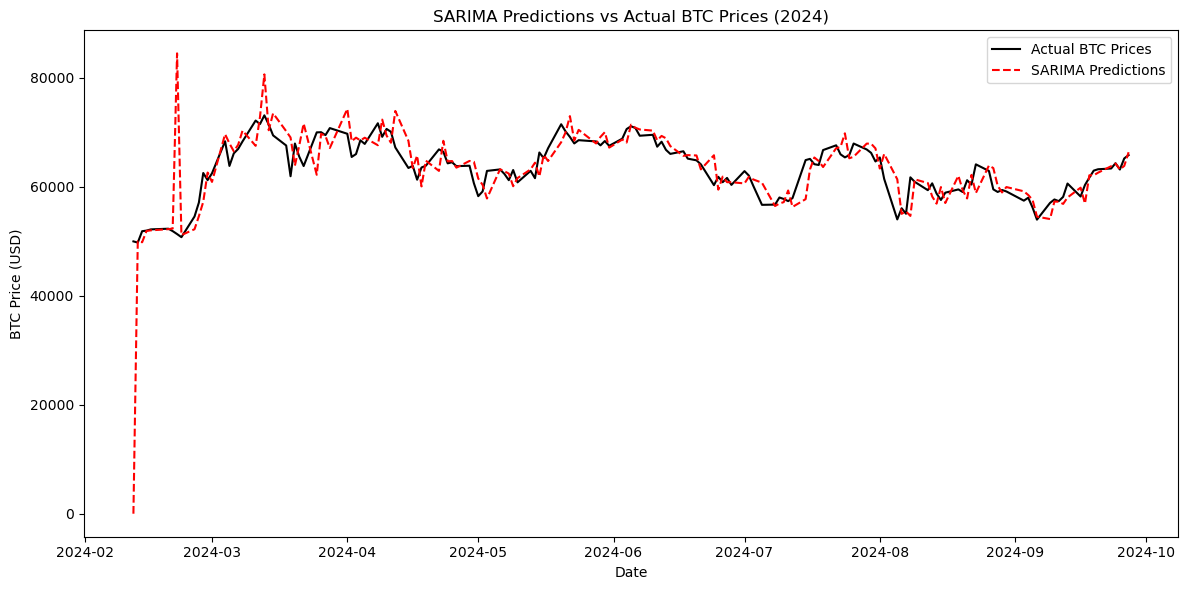

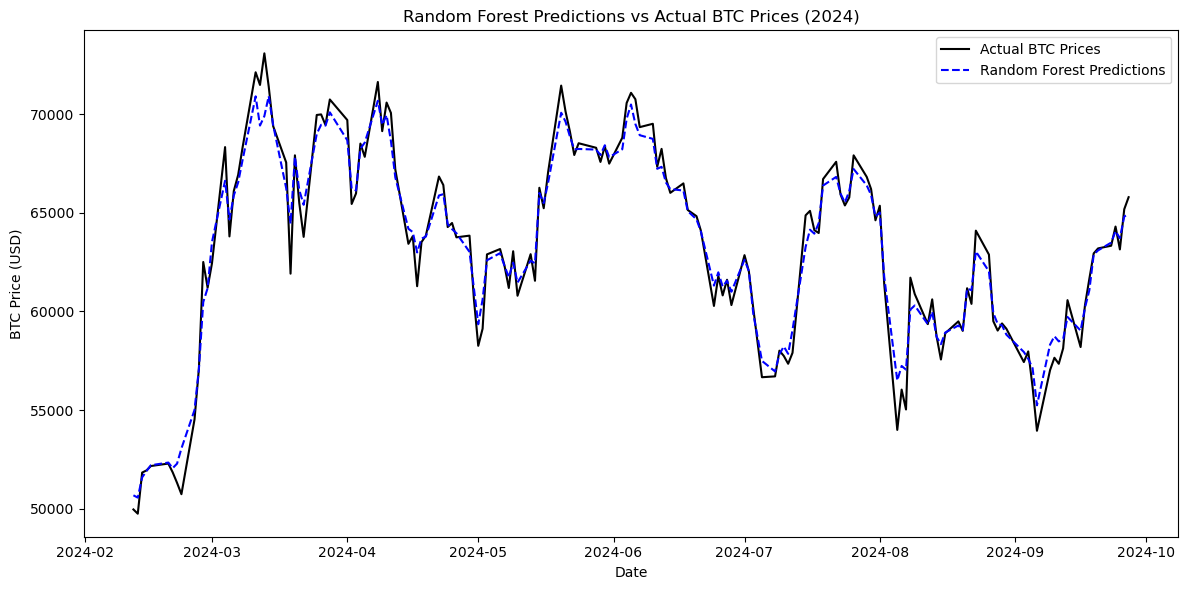

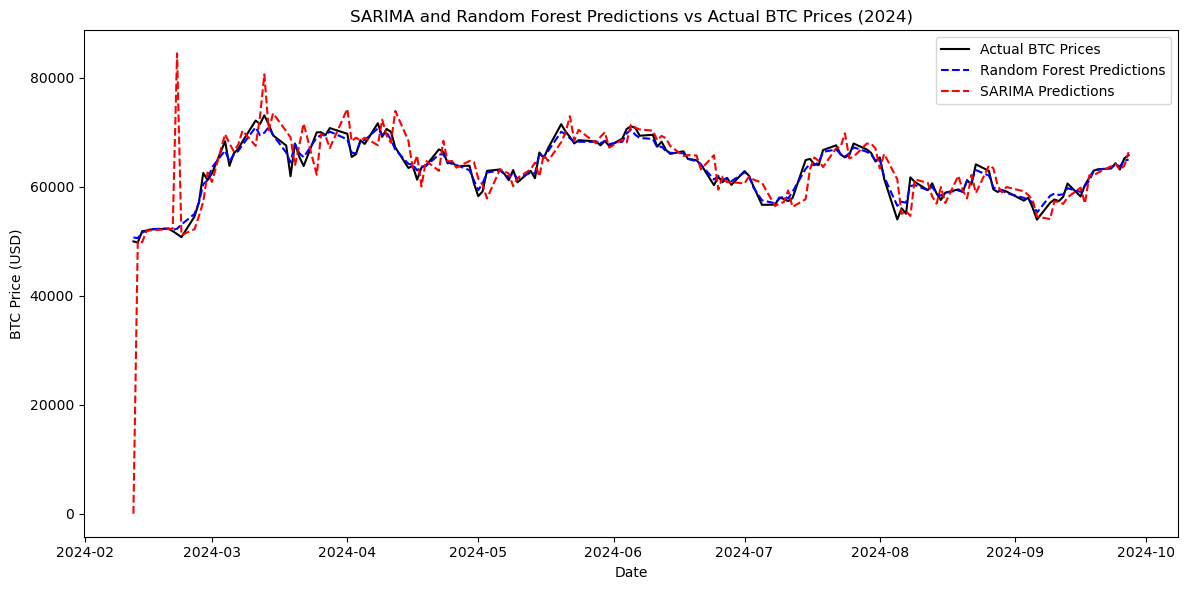

In [50]:
# Module 8: Model Evaluation and Visualization (Actual BTC price vs Predicted BTC Price (7 day estimate)

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import os
from statsmodels.tsa.statespace.sarimax import SARIMAX
import joblib
import yfinance as yf
from sklearn.ensemble import RandomForestRegressor

# Download stock data for each company
stock_symbols = {
    'GOOGL': 'Alphabet Inc.',
    'AMZN': 'Amazon.com, Inc.',
    'META': 'Meta Platforms, Inc.',
    'MSFT': 'Microsoft Corporation',
    'AAPL': 'Apple Inc.'
}
start_date = '2024-01-01'
end_date = '2024-09-30'

# Create a DataFrame for new stock data
new_stock_data = {}
for symbol in stock_symbols:
    stock_data = yf.download(symbol, start=start_date, end=end_date)
    if not stock_data.empty:
        new_stock_data[symbol] = stock_data['Adj Close']

# Convert to DataFrame
new_stock_df = pd.DataFrame(new_stock_data)

# Download BTC data
btc_data = yf.download('BTC-USD', start=start_date, end=end_date)
btc_data = btc_data[['Adj Close']].rename(columns={'Adj Close': 'BTC'})

# Feature engineering for the new data
def create_features(df):
    for col in df.columns:
        df[f'{col}_lag1'] = df[col].shift(1)
        df[f'{col}_lag7'] = df[col].shift(7)
        df[f'{col}_lag14'] = df[col].shift(14)
        df[f'{col}_lag28'] = df[col].shift(28)
        df[f'{col}_rolling7'] = df[col].rolling(window=7).mean()
        df[f'{col}_rolling14'] = df[col].rolling(window=14).mean()
        df[f'{col}_rolling28'] = df[col].rolling(window=28).mean()
        df[f'{col}_EMA12'] = df[col].ewm(span=12, adjust=False).mean()
        df[f'{col}_EMA26'] = df[col].ewm(span=26, adjust=False).mean()
        df[f'{col}_volatility'] = df[col].rolling(window=14).std()
    df.dropna(inplace=True)
    return df

# Apply feature engineering
new_stock_df = create_features(new_stock_df)

# Ensure the columns align with the training data
combined_features = pd.read_csv('combined_data.csv', index_col=0, parse_dates=True).drop(
    columns=['BTC_0d', 'BTC_1d', 'BTC_7d', 'BTC_14d', 'BTC_28d', 'BTC_diff']
)

# Align columns of new_stock_df with combined_features
missing_columns = [col for col in combined_features.columns if col not in new_stock_df.columns]
for col in missing_columns:
    new_stock_df[col] = 0
new_stock_df = new_stock_df.reindex(columns=combined_features.columns)

# Combine new stock features with BTC values
predictions_df = new_stock_df.copy()
predictions_df['Actual_BTC'] = btc_data['BTC']

# Drop any rows with NaNs
predictions_df.dropna(inplace=True)

# Ensure no NaNs exist in predictions_df after dropping
if predictions_df.isna().any().any():
    print("Warning: NaN values found in predictions_df. Dropping NaNs.")
    predictions_df.dropna(inplace=True)

# Check if models exist, otherwise retrain them
if not os.path.exists('random_forest_model.pkl') or not os.path.exists('sarima_model.pkl'):
    print("Pre-trained models not found. Re-training models...")

    # Retrain Random Forest model
    rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
    rf_model.fit(predictions_df[combined_features.columns], predictions_df['Actual_BTC'])
    joblib.dump(rf_model, 'random_forest_model.pkl')
    
    # Retrain SARIMA model
    sarima_model = SARIMAX(predictions_df['Actual_BTC'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
    sarima_fit = sarima_model.fit(disp=False)
    joblib.dump(sarima_fit, 'sarima_model.pkl')
else:
    # Load pre-trained models if they exist
    rf_model = joblib.load('random_forest_model.pkl')
    sarima_fit = joblib.load('sarima_model.pkl')

# Make predictions using the Random Forest model
rf_predictions = rf_model.predict(predictions_df[combined_features.columns])

# Make predictions using the SARIMA model for the entire period
sarima_predictions = sarima_fit.predict(start=0, end=len(predictions_df) - 1)

# Add predictions and calculate deltas
predictions_df['RandomForest_Pred'] = rf_predictions
predictions_df['SARIMA_Pred'] = sarima_predictions
predictions_df['Delta_SARIMA'] = predictions_df['Actual_BTC'] - predictions_df['SARIMA_Pred']
predictions_df['Delta_RF'] = predictions_df['Actual_BTC'] - predictions_df['RandomForest_Pred']

# Save the predictions and deltas to a CSV file with only specified columns
output_columns = ['Actual_BTC', 'RandomForest_Pred', 'SARIMA_Pred', 'Delta_SARIMA', 'Delta_RF']
predictions_df[output_columns].to_csv('btc_predictions_deltas.csv', index=True)
print("Predictions and deltas saved to 'btc_predictions_deltas.csv'.")

# Plotting the SARIMA predictions vs actual BTC prices
plt.figure(figsize=(12, 6))
plt.plot(predictions_df.index, predictions_df['Actual_BTC'], label='Actual BTC Prices', linestyle='-', color='black')
plt.plot(predictions_df.index, predictions_df['SARIMA_Pred'], label='SARIMA Predictions', linestyle='--', color='red')
plt.title('SARIMA Predictions vs Actual BTC Prices (2024)')
plt.xlabel('Date')
plt.ylabel('BTC Price (USD)')
plt.legend()
plt.tight_layout()
plt.savefig('plots/sarima_vs_actual_btc_prices.png')
plt.show()

# Plotting the Random Forest predictions vs actual BTC prices
plt.figure(figsize=(12, 6))
plt.plot(predictions_df.index, predictions_df['Actual_BTC'], label='Actual BTC Prices', linestyle='-', color='black')
plt.plot(predictions_df.index, predictions_df['RandomForest_Pred'], label='Random Forest Predictions', linestyle='--', color='blue')
plt.title('Random Forest Predictions vs Actual BTC Prices (2024)')
plt.xlabel('Date')
plt.ylabel('BTC Price (USD)')
plt.legend()
plt.tight_layout()
plt.savefig('plots/randomforest_vs_actual_btc_prices.png')
plt.show()

# Combined plot of both models vs actual BTC prices
plt.figure(figsize=(12, 6))
plt.plot(predictions_df.index, predictions_df['Actual_BTC'], label='Actual BTC Prices', linestyle='-', color='black')
plt.plot(predictions_df.index, predictions_df['RandomForest_Pred'], label='Random Forest Predictions', linestyle='--', color='blue')
plt.plot(predictions_df.index, predictions_df['SARIMA_Pred'], label='SARIMA Predictions', linestyle='--', color='red')
plt.title('SARIMA and Random Forest Predictions vs Actual BTC Prices (2024)')
plt.xlabel('Date')
plt.ylabel('BTC Price (USD)')
plt.legend()
plt.tight_layout()
plt.savefig('plots/combined_vs_actual_btc_prices.png')
plt.show()



In [52]:
# Module 9 - Lets calculate how much could be made if we used these models in their current state to trade
# Buying one BTC every time the model predicts the price will be higher in 7 days and then selling it in 7
# days and tracking actual gain (or loss)

import pandas as pd

# Load the predictions data
predictions_df = pd.read_csv('btc_predictions_deltas.csv', index_col=0, parse_dates=True)

# Initialize totals
sarima_spent = 0
sarima_realized = 0
rf_spent = 0
rf_realized = 0

# Get the starting and ending prices of BTC for the analysis period
btc_start_price = predictions_df['Actual_BTC'].iloc[0]
btc_end_price = predictions_df['Actual_BTC'].iloc[-1]
btc_percentage_change = ((btc_end_price - btc_start_price) / btc_start_price) * 100

# Iterate through the DataFrame to simulate the trading strategy
for i in range(len(predictions_df) - 7):
    current_date = predictions_df.index[i]
    future_date = predictions_df.index[i + 7]
    
    # Actual BTC price on the current date and 7 days later
    current_actual_price = predictions_df.loc[current_date, 'Actual_BTC']
    future_actual_price = predictions_df.loc[future_date, 'Actual_BTC']
    
    # SARIMA prediction and Random Forest prediction for the current date
    sarima_prediction = predictions_df.loc[current_date, 'SARIMA_Pred']
    rf_prediction = predictions_df.loc[current_date, 'RandomForest_Pred']
    
    # SARIMA trading logic
    if sarima_prediction > current_actual_price:
        sarima_spent += current_actual_price  # Record the cost of buying 1 BTC
        sarima_realized += future_actual_price  # Record the revenue from selling 1 BTC

    # Random Forest trading logic
    if rf_prediction > current_actual_price:
        rf_spent += current_actual_price  # Record the cost of buying 1 BTC
        rf_realized += future_actual_price  # Record the revenue from selling 1 BTC

# Calculate total gain/loss and percentage gain/loss
sarima_gain = sarima_realized - sarima_spent
sarima_gain_percent = (sarima_gain / sarima_spent * 100) if sarima_spent != 0 else 0

rf_gain = rf_realized - rf_spent
rf_gain_percent = (rf_gain / rf_spent * 100) if rf_spent != 0 else 0

# Prepare the output as a formatted string
output = (
    "----- Trading Strategy Results -----\n"
    f"Starting BTC Price (2024-01-01): ${btc_start_price:,.2f}\n"
    f"Ending BTC Price (2024-09-30): ${btc_end_price:,.2f}\n"
    f"BTC Price Percentage Change: {btc_percentage_change:.2f}%\n\n"
    "SARIMA Model:\n"
    f"Total spent purchasing BTC: ${sarima_spent:,.2f}\n"
    f"Total realized from selling BTC: ${sarima_realized:,.2f}\n"
    f"Total gain/loss: ${sarima_gain:,.2f}\n"
    f"Percentage gain/loss: {sarima_gain_percent:.2f}%\n\n"
    "Random Forest Model:\n"
    f"Total spent purchasing BTC: ${rf_spent:,.2f}\n"
    f"Total realized from selling BTC: ${rf_realized:,.2f}\n"
    f"Total gain/loss: ${rf_gain:,.2f}\n"
    f"Percentage gain/loss: {rf_gain_percent:.2f}%\n"
)

# Print the output to the console
print(output)

# Write the output to a text file
with open('trading_strategy_results.txt', 'w') as file:
    file.write(output)



----- Trading Strategy Results -----
Starting BTC Price (2024-01-01): $49,958.22
Ending BTC Price (2024-09-30): $65,790.66
BTC Price Percentage Change: 31.69%

SARIMA Model:
Total spent purchasing BTC: $5,485,166.23
Total realized from selling BTC: $5,550,048.20
Total gain/loss: $64,881.97
Percentage gain/loss: 1.18%

Random Forest Model:
Total spent purchasing BTC: $4,165,978.86
Total realized from selling BTC: $4,349,286.58
Total gain/loss: $183,307.72
Percentage gain/loss: 4.40%

